In [240]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
#import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time

In [241]:
train_path ='data/train'
test_path = "data/test"
valid_path='data/val'
list_of_classes=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']
for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels=[] 
    classlist=os.listdir(d)   
    for klass in classlist:
        intklass=int(klass)
        label=list_of_classes[intklass]
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)        
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    elif d == valid_path:
        valid_df=pdf
    else:
        train_df=pdf
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  5778   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     
Healthy  has the most images=  2286   Severe  has the least images=  173
average height=  224  average width=  224 aspect ratio=  1.0


In [242]:
train_df.sample(5)
valid_df.sample(5)
test_df.sample(2)

,filepaths,labels
431,data/test/2/9142551L.png,Minimal
56,data/test/2/9895675R.png,Minimal


In [243]:
healthy = test_df[test_df.labels == "Healthy"].head(2).reset_index(drop=True)
doubtful = test_df[test_df.labels == "Doubtful"].head(2).reset_index(drop=True)
moderate = test_df[test_df.labels == "Moderate"].head(2).reset_index(drop=True)
minimal = test_df[test_df.labels == "Minimal"].head(2).reset_index(drop=True)
severe = test_df[test_df.labels == "Severe"].head(2).reset_index(drop=True)

In [244]:
healthy

,filepaths,labels
0,data/test/0/9070290R.png,Healthy
1,data/test/0/9721192L.png,Healthy


In [245]:
moderate

,filepaths,labels
0,data/test/3/9660697R.png,Moderate
1,data/test/3/9232078L.png,Moderate


In [246]:
minimal

,filepaths,labels
0,data/test/2/9009957R.png,Minimal
1,data/test/2/9616228L.png,Minimal


In [247]:
severe

,filepaths,labels
0,data/test/4/9772692L.png,Severe
1,data/test/4/9479978L.png,Severe


In [248]:
from PIL import Image
h1 = np.asarray(Image.open(healthy.filepaths[0]))
h2 = np.asarray(Image.open(healthy.filepaths[1]))
mod1 = np.asarray(Image.open(moderate.filepaths[0]))
mod2 = np.asarray(Image.open(moderate.filepaths[1]))
db1 = np.asarray(Image.open(doubtful.filepaths[0]))
db2 = np.asarray(Image.open(doubtful.filepaths[1]))
min1 = np.asarray(Image.open(minimal.filepaths[0]))
min2 = np.asarray(Image.open(minimal.filepaths[1]))
sev1 = np.asarray(Image.open(severe.filepaths[0]))
sev2 = np.asarray(Image.open(severe.filepaths[1]))

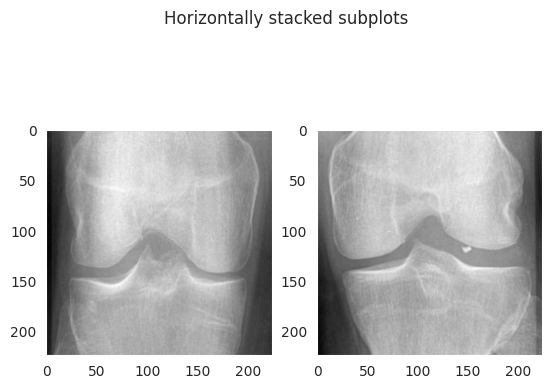

In [249]:

img = np.asarray(Image.open('data/train/0/9001695L.png'))
#print(repr(img))
#imgplot = plt.imshow(X=img, cmap="gray")
# plt.grid(None)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.imshow(h1, cmap="gray")
ax1.grid(None)
ax2.imshow(h2, cmap="gray")
plt.grid(None)

In [250]:
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

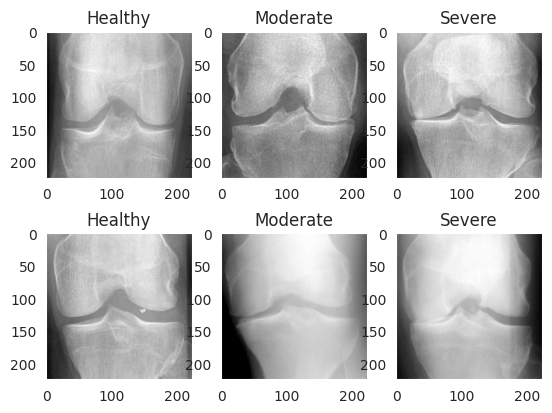

In [251]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].imshow(h1, cmap="gray")
axs[0, 0].set_title('Healthy')
axs[0,0].grid(None)
axs[1, 0].imshow(h2, cmap="gray")
axs[1, 0].set_title('Healthy')
axs[1, 0].grid(None)

axs[0, 1].imshow(mod1, cmap="gray")
axs[0, 1].set_title('Moderate')
axs[0, 1].grid(None)
axs[1, 1].imshow(mod2, cmap="gray")
axs[1, 1].set_title('Moderate')
axs[1, 1].grid(None)

axs[0, 2].imshow(sev1, cmap = "gray") 
axs[0, 2].set_title('Severe')
axs[0, 2].grid(None)
axs[1,2].imshow(sev2, cmap = "gray") 
axs[1, 2].set_title('Severe')
plt.grid(None)
# axs[0,3].imshow(mod1, cmap = "gray") 
# axs[1,3].imshow(mod2, cmap = "gray") 
# axs[0,4].imshow(sev1, cmap = "gray") 
# axs[1,4].imshow(sev2, cmap = "gray") 
fig.savefig("x_ray", dpi = fig.dpi)

# Knee Osteoarthritis Dataset with Severity Grading

> Kristjan Qarri <br>LeWagon 1402 <br> November 2023

# Agenda
___
<br>Motivation
<br>Data
<br>Methods & Tools
<br>Goals

# Motivation
___


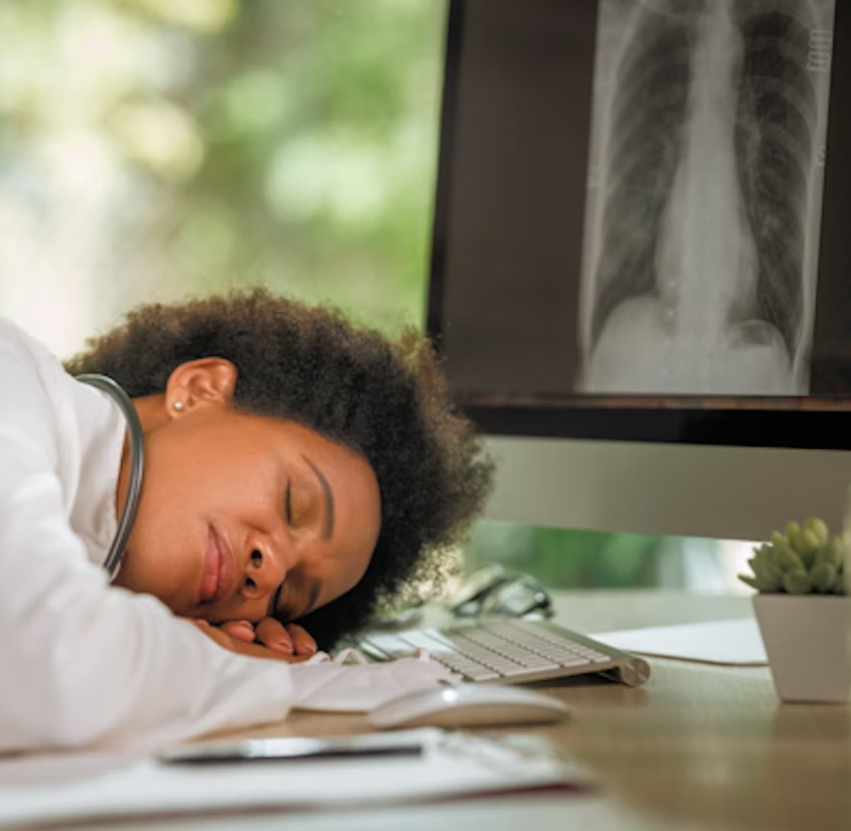

In [267]:
Image(filename='images/dr_tired.png', width = 300) 

Tired Doctors => Not Good!

### But What Can We Do About it???

Reduce the wokload!


# Data
___

9786 .png images <br>
five severity classes <br>
train / validation / test sets defined <br>
link to [data](https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity/data) in Kaggle

In [254]:
train_df.describe()

,filepaths,labels
count,5778,5778
unique,5778,5
top,data/train/2/9589653R.png,Healthy
freq,1,2286


In [255]:
train_df.sample(3)

,filepaths,labels
4531,data/train/1/9268052R.png,Doubtful
4523,data/train/1/9345493R.png,Doubtful
3847,data/train/0/9947742R.png,Healthy


In [256]:
valid_df.sample(3)

,filepaths,labels
30,data/val/2/9878871L.png,Minimal
419,data/val/0/9430117R.png,Healthy
253,data/val/0/9804376L.png,Healthy


In [257]:
test_df.sample(3)

,filepaths,labels
1073,data/test/0/9271853R.png,Healthy
722,data/test/0/9508414R.png,Healthy
933,data/test/0/9456857L.png,Healthy


## Label

Grade 0: Healthy knee image <br>
Grade 1 (Doubtful): Doubtful joint narrowing with possible osteophytic lipping<br>
Grade 2 (Minimal): Definite presence of osteophytes and possible joint space narrowing<br>
Grade 3 (Moderate): Multiple osteophytes, definite joint space narrowing, with mild sclerosis<br>
Grade 4 (Severe): Large osteophytes, significant joint narrowing, and severe sclerosis<br>

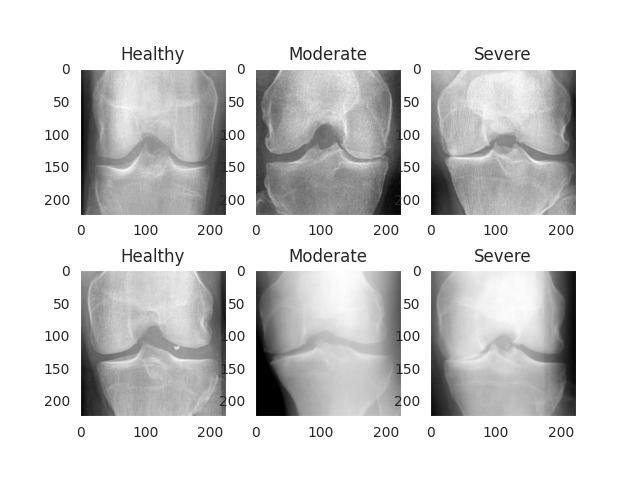

In [266]:
from IPython.display import Image
Image(filename='images/x_ray.png', width = 900) 

# Methods & Tools 
___

Classification task: Convolutional Neural Networks(CNN)<br>
Pre-trained models: EfficientNetB5 & VGG-n<br>
Five classes vs three classes <br>
<br>
### Preprocessing data and model creation 
<br>
Train set Balancing 200-500 images/ class<br>
Create the model using callbacks <br>
Train the model <br>



## Hosting The model


1. Set up a server using Google Cloud 
2. Expose an API 
    - Handling incoming requests, run the model, return predictions 
    - Flask and FastAPI are popular frameworks for creating APIs in Python
4. Load the pre-trained CNN model  
5. Define an endpoint in your API that will receive input data for making predictions 
6. Make Predictions 
7. Return results 



In [ ]:
# Goals
___
Build a webpage to call the and visualize the predictions from the model

In [287]:
# from IPython.display import HTML

# # Replace this URL with the actual URL of your HTML file on GitHub
# github_html_url = "https://github.com/chrissMD/data-notebook/commit/a114366105d6929e81f48ef6206845878a77c6a7"
# # Create a clickable link in Markdown format
# markdown_link = f'[Open HTML Page]({github_html_url})'

# # Create a clickable link in Markdown format
# markdown_link = f'[Open HTML Page]({github_html_url})'

# # Display the link in the notebook
# display(Markdown(markdown_link))

# Questions 
___

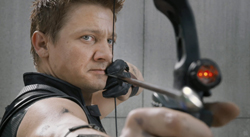

In [270]:
Image(filename='images/bow_arrow.jpg', width = 600) 